In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [3]:
ds['train'][2]['article'][:300]

'MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. "The whole bridge from one side of the Mississippi to the other just completely gave way, fell all the way down," survivor Gary Babineau told CNN. "I probably had a 30-, 35-'

In [4]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [5]:


device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [6]:

samsum = load_dataset('samsum')
samsum

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [7]:

dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

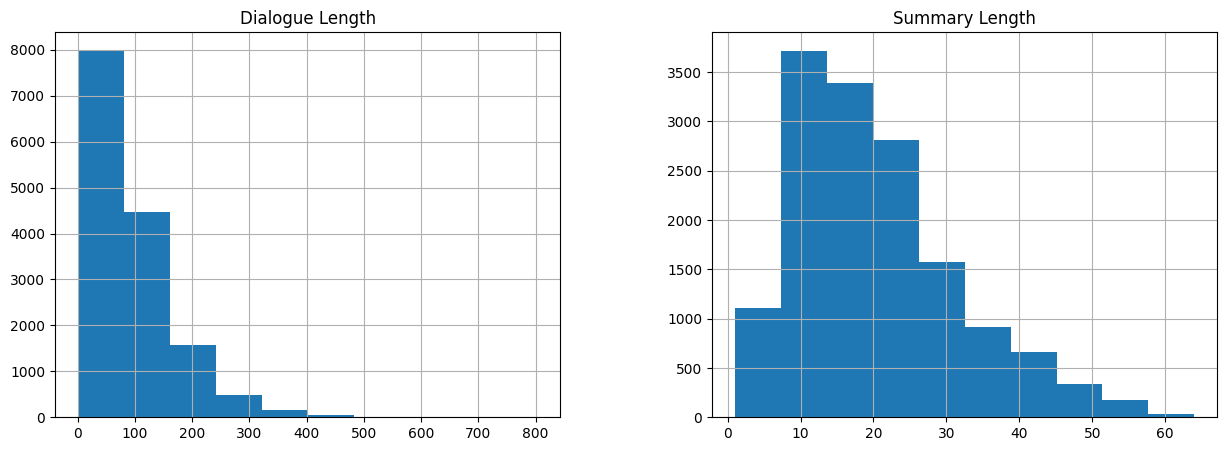

In [8]:

import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))


In [9]:


# lets build Data Collator

def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings


In [10]:
samsum_pt = samsum.map(get_feature, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [11]:

columns = ['input_ids', 'labels', 'attention_mask']
samsum_pt.set_format(type='torch', columns=columns)

In [12]:

from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:646: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss


TrainOutput(global_step=230, training_loss=1.4832450410594111, metrics={'train_runtime': 1900.0658, 'train_samples_per_second': 7.753, 'train_steps_per_second': 0.121, 'total_flos': 8823027777404928.0, 'train_loss': 1.4832450410594111, 'epoch': 0.9991854466467553})

In [15]:

trainer.save_model('bart_samsum_model')



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [16]:
# custome Dialogue Prediction

pipe = pipeline('summarization', model='bart_samsum_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

custom_dialogue="""
Laxmi Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Laxmi Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""
print(pipe(custom_dialogue, **gen_kwargs))

Your max_length is set to 128, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


[{'summary_text': "Juli wants to send Tom on a business trip first. She will assign him a new project once he is back. Tom did excellent work in last quarter, so she will send him the new project to Laxmi Kant as soon as he's back."}]


In [17]:

!zip bart_samsum.zip -r bart_samsum_model/

  adding: bart_samsum_model/ (stored 0%)
  adding: bart_samsum_model/training_args.bin (deflated 51%)
  adding: bart_samsum_model/model.safetensors (deflated 7%)
  adding: bart_samsum_model/tokenizer.json (deflated 72%)
  adding: bart_samsum_model/generation_config.json (deflated 48%)
  adding: bart_samsum_model/config.json (deflated 61%)
  adding: bart_samsum_model/vocab.json (deflated 59%)
  adding: bart_samsum_model/special_tokens_map.json (deflated 52%)
  adding: bart_samsum_model/tokenizer_config.json (deflated 75%)
  adding: bart_samsum_model/merges.txt (deflated 53%)
